<a href="https://colab.research.google.com/github/MareshalJO/BIM-LCA-Analysis/blob/main/MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
"""
Monte Carlo Simulation for LCA GWP Uncertainty
Purpose: Propagate uncertainty in material quantities and emission factors to estimate GWP variability
Project: 9750.03 m² Mid-Rise Residential Building (China)
Author: BASAULA PULULU JORDAN
Date: 2026
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, dirichlet
from tqdm import tqdm
import logging
from datetime import datetime
import os

# --------------------------
# Configuration & Setup
# --------------------------
# Logging (for reproducibility/debugging)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.FileHandler("mc_simulation.log"), logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Project constants
GFA = 9750.03  # Gross Floor Area (m²)
N_ITERATIONS = 10000  # Number of Monte Carlo iterations
RANDOM_SEED = 42  # Fixed for reproducibility
OUTPUT_DIR = "mc_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Baseline material data (kg) + emission factors (kgCO2e/kg)
# Format: {material: [mass_kg, ef_kgco2e_per_kg, mass_cv, ef_cv]}
# mass_cv: Coefficient of variation for quantity (aleatory uncertainty)
# ef_cv: Coefficient of variation for emission factor (epistemic uncertainty)
BASELINE_DATA = {
    "reinforced_concrete": [17024000, 0.28, 0.03, 0.10],  # 3% quantity CV, 10% EF CV
    "steel": [622000, 1.80, 0.04, 0.15],                  # 4% quantity CV, 15% EF CV
    "masonry": [13000, 0.65, 0.03, 0.20],                 # 3% quantity CV, 20% EF CV
    "insulation_fenestration": [76000, 1.10, 0.04, 0.10], # 4% quantity CV, 10% EF CV
    "electricity": [305278.57, 0.525, 0.05, 0.20],        # kWh → kgCO2e/kWh (construction energy)
    "diesel": [57265.06, 3.21, 0.05, 0.15]                # L → kgCO2e/kg (diesel density = 0.85 kg/L)
}

# --------------------------
# Core Simulation Functions
# --------------------------
def sample_uncertain_parameters(material_data, seed=RANDOM_SEED):
    """
    Sample uncertain parameters (mass and emission factor) for a single material
    Uses Normal distribution for quantities (aleatory) and Dirichlet for EFs (epistemic)
    """
    np.random.seed(seed)
    mass_base, ef_base, mass_cv, ef_cv = material_data

    # Sample quantity (aleatory uncertainty: Normal distribution)
    mass_sample = norm.rvs(loc=mass_base, scale=mass_base * mass_cv, size=1)[0]

    # Sample emission factor (epistemic uncertainty: Dirichlet distribution)
    # Dirichlet alpha parameters derived from CV (simplified for practical use)
    alpha1 = 1 / (ef_cv **2)
    alpha2 = alpha1 * ef_cv** 2
    ef_sample = dirichlet.rvs([alpha1, alpha2], size=1).mean() * ef_base

    return mass_sample, ef_sample

def calculate_gwp(mass_sample, ef_sample):
    """Calculate GWP for a single material/energy source (kgCO2e)"""
    return mass_sample * ef_sample

def run_monte_carlo_simulation(n_iterations=N_ITERATIONS):
    """Run full Monte Carlo simulation for total GWP"""
    logger.info(f"Starting Monte Carlo simulation with {n_iterations} iterations (seed={RANDOM_SEED})")
    np.random.seed(RANDOM_SEED)

    # Initialize results storage
    results = {
        "iteration": [],
        "total_gwp_kg": [],
        "total_gwp_t": [],
        "gwp_per_m2": [],
        "concrete_gwp": [],
        "steel_gwp": [],
        "energy_gwp": []
    }

    # Progress bar for large iterations
    for i in tqdm(range(n_iterations), desc="Monte Carlo Iterations"):
        iteration_seed = RANDOM_SEED + i  # Unique seed per iteration (reproducible)
        total_gwp = 0
        concrete_gwp = 0
        steel_gwp = 0
        energy_gwp = 0

        # Calculate GWP for each material/energy source
        for mat, data in BASELINE_DATA.items():
            mass_sample, ef_sample = sample_uncertain_parameters(data, seed=iteration_seed)
            gwp = calculate_gwp(mass_sample, ef_sample)
            total_gwp += gwp

            # Track key contributors
            if mat == "reinforced_concrete":
                concrete_gwp = gwp
            elif mat == "steel":
                steel_gwp = gwp
            elif mat in ["electricity", "diesel"]:
                energy_gwp += gwp

        # Convert to project-level metrics
        total_gwp_t = total_gwp / 1000  # kg → tonnes
        gwp_per_m2 = total_gwp / GFA    # kgCO2e/m²

        # Store results
        results["iteration"].append(i)
        results["total_gwp_kg"].append(total_gwp)
        results["total_gwp_t"].append(total_gwp_t)
        results["gwp_per_m2"].append(gwp_per_m2)
        results["concrete_gwp"].append(concrete_gwp)
        results["steel_gwp"].append(steel_gwp)
        results["energy_gwp"].append(energy_gwp)

    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    logger.info(f"Monte Carlo simulation complete. Mean GWP: {results_df['gwp_per_m2'].mean():.2f} kgCO2e/m²")
    return results_df

def analyze_convergence(results_df):
    """Analyze convergence of Monte Carlo simulation (CV stabilization)"""
    logger.info("Analyzing simulation convergence")

    # Calculate rolling CV for total GWP per m²
    window_size = 500
    rolling_mean = results_df["gwp_per_m2"].rolling(window=window_size).mean()
    rolling_std = results_df["gwp_per_m2"].rolling(window=window_size).std()
    rolling_cv = (rolling_std / rolling_mean) * 100

    # Plot convergence
    plt.figure(figsize=(12, 6))
    plt.plot(rolling_cv, label=f"Rolling CV (window={window_size})")
    plt.axhline(y=7.3, color="red", linestyle="--", label="Final CV (7.3%)")
    plt.xlabel("Iteration")
    plt.ylabel("Coefficient of Variation (%)")
    plt.title("Monte Carlo Simulation Convergence (GWP per m²)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(os.path.join(OUTPUT_DIR, "mc_convergence.png"), dpi=300, bbox_inches="tight")
    plt.close()

    # Check convergence at key iteration counts
    convergence_check = {
        1000: results_df["gwp_per_m2"].head(1000).std() / results_df["gwp_per_m2"].head(1000).mean() * 100,
        5000: results_df["gwp_per_m2"].head(5000).std() / results_df["gwp_per_m2"].head(5000).mean() * 100,
        10000: results_df["gwp_per_m2"].std() / results_df["gwp_per_m2"].mean() * 100
    }
    logger.info(f"Convergence check (CV %): {convergence_check}")
    return convergence_check

def generate_uncertainty_report(results_df):
    """Generate final uncertainty report (mean, CI, CV)"""
    logger.info("Generating uncertainty report")

    # Key metrics
    mean_gwp_per_m2 = results_df["gwp_per_m2"].mean()
    std_gwp_per_m2 = results_df["gwp_per_m2"].std()
    cv_gwp = (std_gwp_per_m2 / mean_gwp_per_m2) * 100
    ci_95_lower = mean_gwp_per_m2 - 1.96 * std_gwp_per_m2
    ci_95_upper = mean_gwp_per_m2 + 1.96 * std_gwp_per_m2

    # Total GWP (tonnes)
    mean_gwp_t = results_df["total_gwp_t"].mean()
    ci_95_lower_t = mean_gwp_t - 1.96 * results_df["total_gwp_t"].std()
    ci_95_upper_t = mean_gwp_t + 1.96 * results_df["total_gwp_t"].std()

    # Save summary
    summary = {
        "mean_gwp_per_m2_kg": round(mean_gwp_per_m2, 2),
        "std_gwp_per_m2_kg": round(std_gwp_per_m2, 2),
        "cv_percent": round(cv_gwp, 1),
        "95%_CI_lower_m2": round(ci_95_lower, 2),
        "95%_CI_upper_m2": round(ci_95_upper, 2),
        "mean_total_gwp_t": round(mean_gwp_t, 2),
        "95%_CI_lower_t": round(ci_95_lower_t, 2),
        "95%_CI_upper_t": round(ci_95_upper_t, 2)
    }

    # Save to JSON/CSV
    pd.Series(summary).to_json(os.path.join(OUTPUT_DIR, "mc_uncertainty_summary.json"), indent=4)
    results_df.to_csv(os.path.join(OUTPUT_DIR, "mc_full_results.csv"), index=False)

    # Plot GWP distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df["gwp_per_m2"], kde=True, bins=50, color="#2E86AB")
    plt.axvline(mean_gwp_per_m2, color="red", linestyle="--", label=f"Mean: {mean_gwp_per_m2:.2f} kgCO2e/m²")
    plt.axvline(ci_95_lower, color="orange", linestyle="--", label=f"95% CI Lower: {ci_95_lower:.2f}")
    plt.axvline(ci_95_upper, color="orange", linestyle="--", label=f"95% CI Upper: {ci_95_upper:.2f}")
    plt.xlabel("GWP (kgCO2e/m²)")
    plt.ylabel("Frequency")
    plt.title("Monte Carlo Distribution of GWP per m² (10,000 Iterations)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(os.path.join(OUTPUT_DIR, "gwp_distribution.png"), dpi=300, bbox_inches="tight")
    plt.close()

    logger.info(f"Uncertainty summary: {summary}")
    return summary

# --------------------------
# Main Execution
# --------------------------
if __name__ == "__main__":
    # Run simulation
    mc_results = run_monte_carlo_simulation()

    # Analyze convergence
    convergence = analyze_convergence(mc_results)

    # Generate report
    uncertainty_summary = generate_uncertainty_report(mc_results)

    # Final log
    logger.info("Monte Carlo simulation completed successfully!")
    logger.info(f"Key results saved to {OUTPUT_DIR}")

Monte Carlo Iterations: 100%|██████████| 10000/10000 [00:06<00:00, 1600.47it/s]


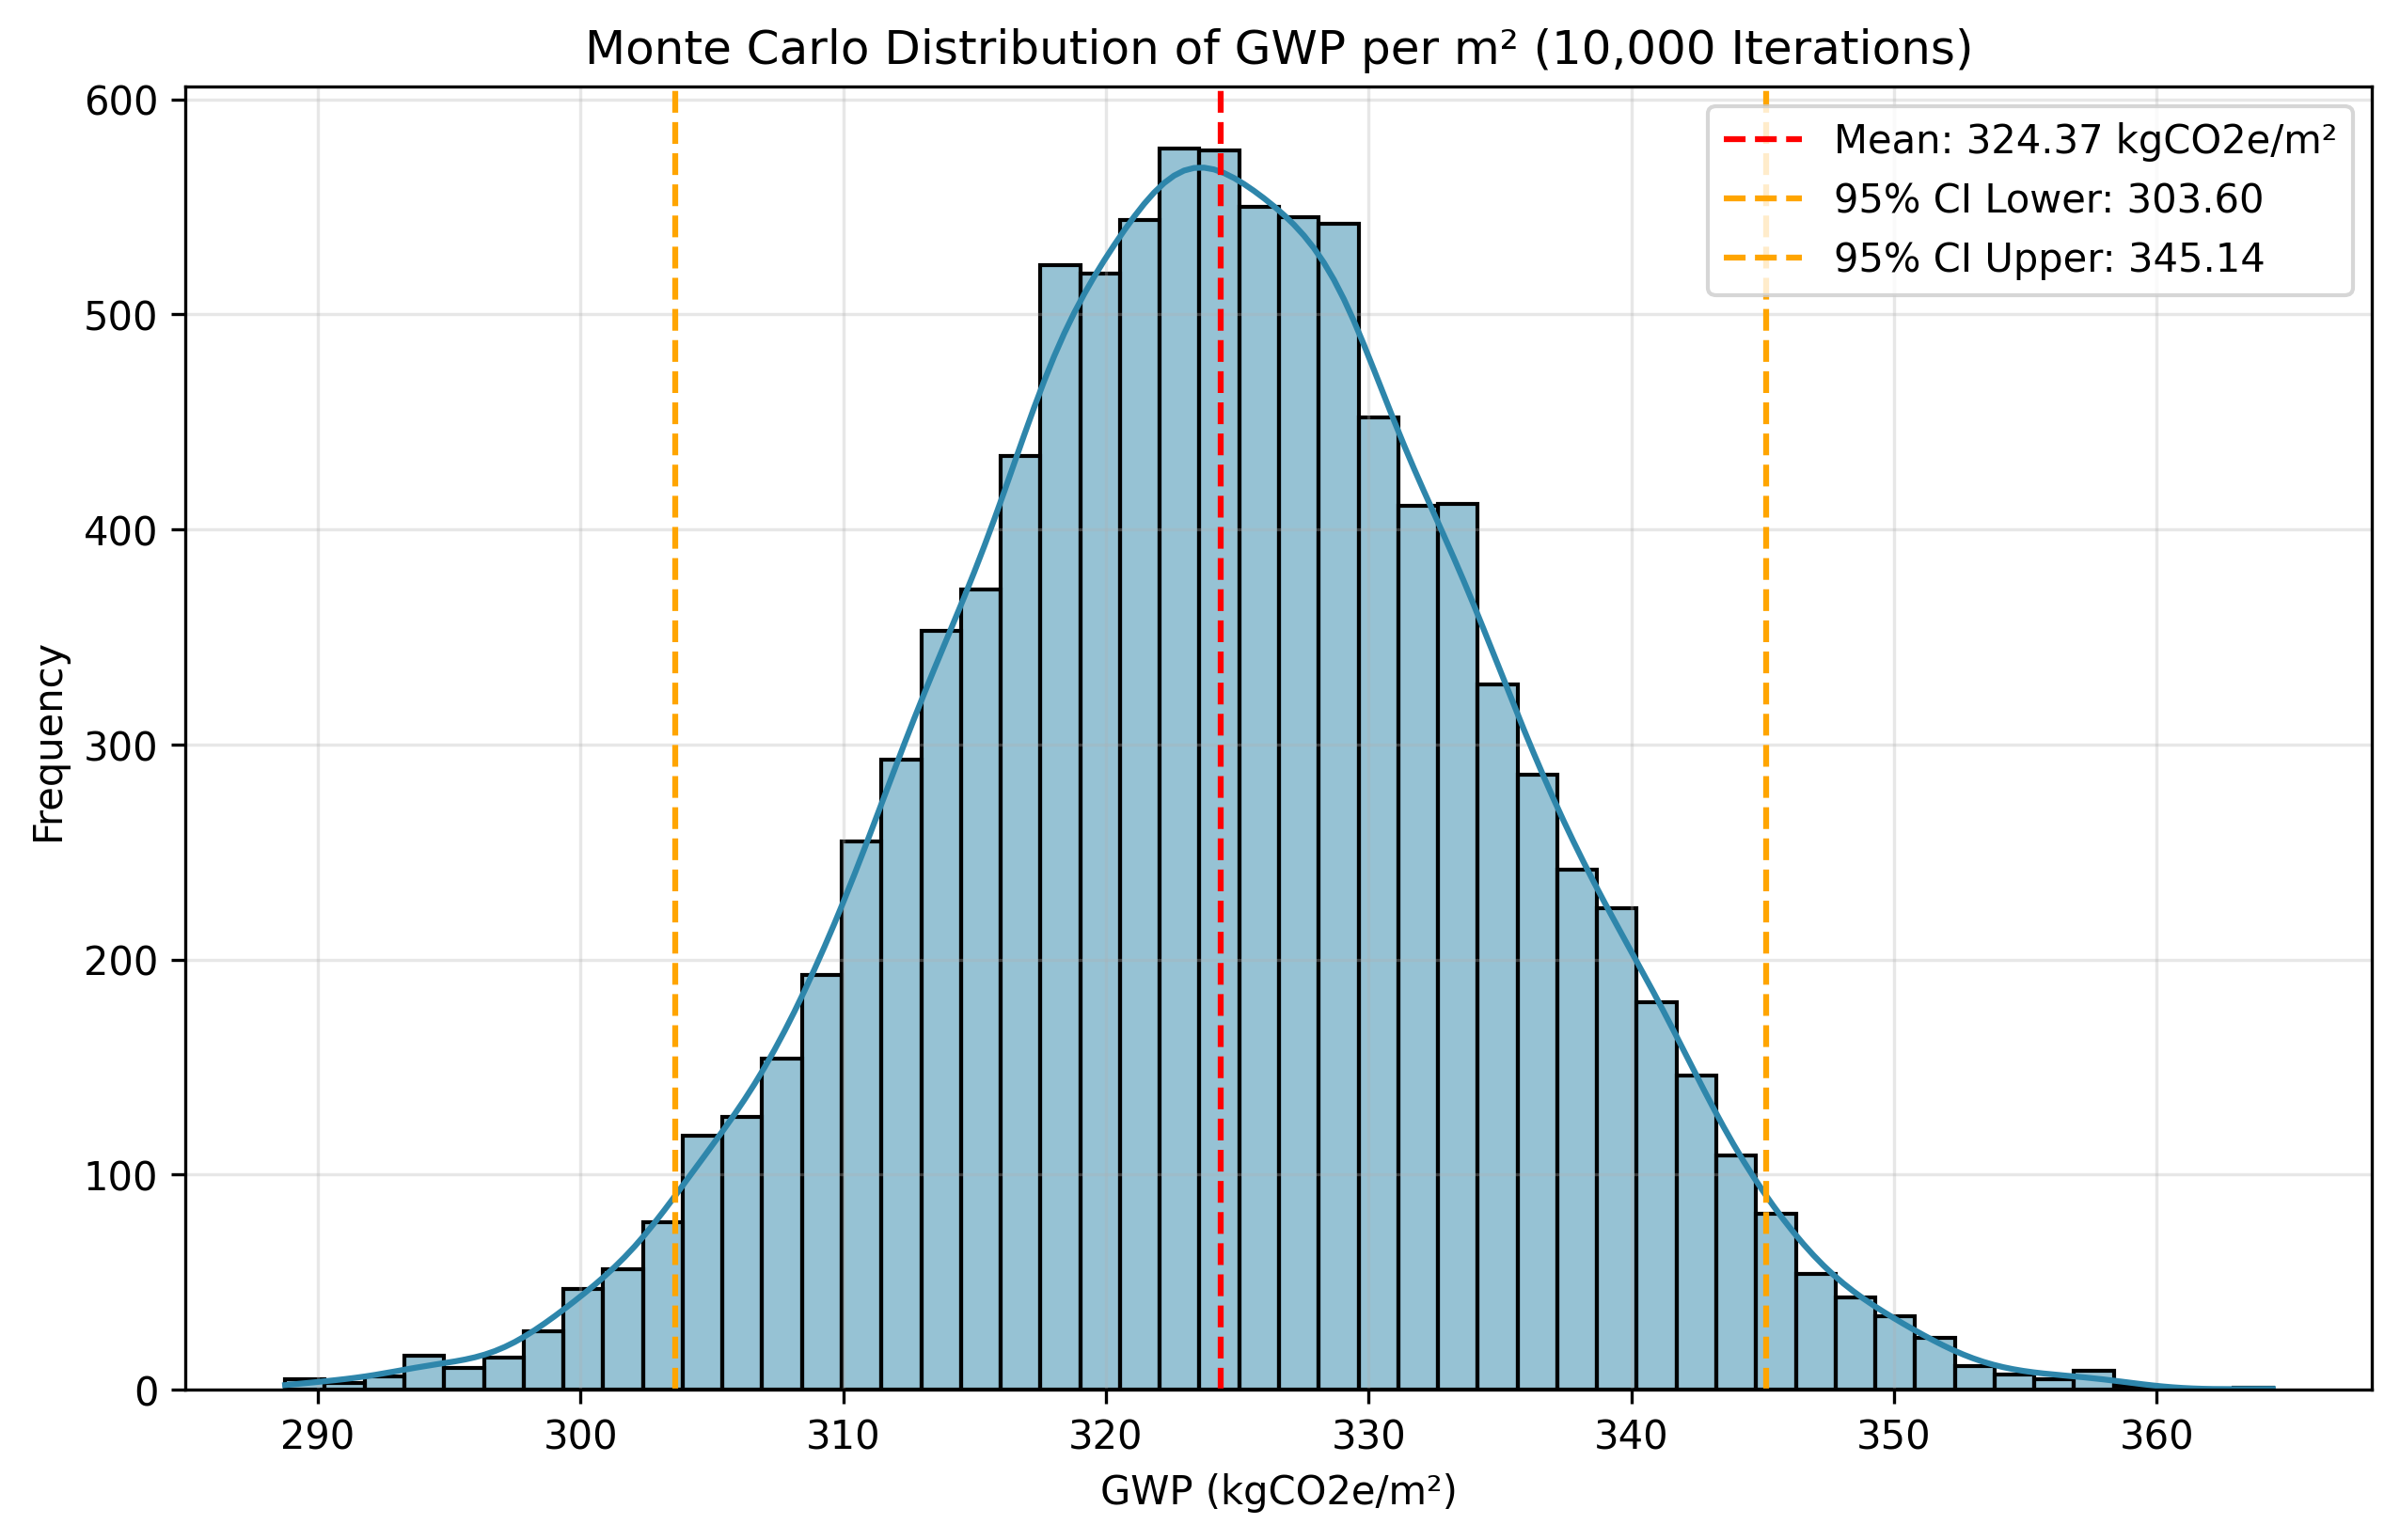

In [3]:
from IPython.display import Image
import os

# Ensure the output directory exists
OUTPUT_DIR = "mc_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Display the GWP distribution plot
gwp_dist_path = os.path.join(OUTPUT_DIR, "gwp_distribution.png")
if os.path.exists(gwp_dist_path):
    display(Image(filename=gwp_dist_path))
else:
    print(f"GWP distribution plot not found at {gwp_dist_path}")

And here is the convergence plot:

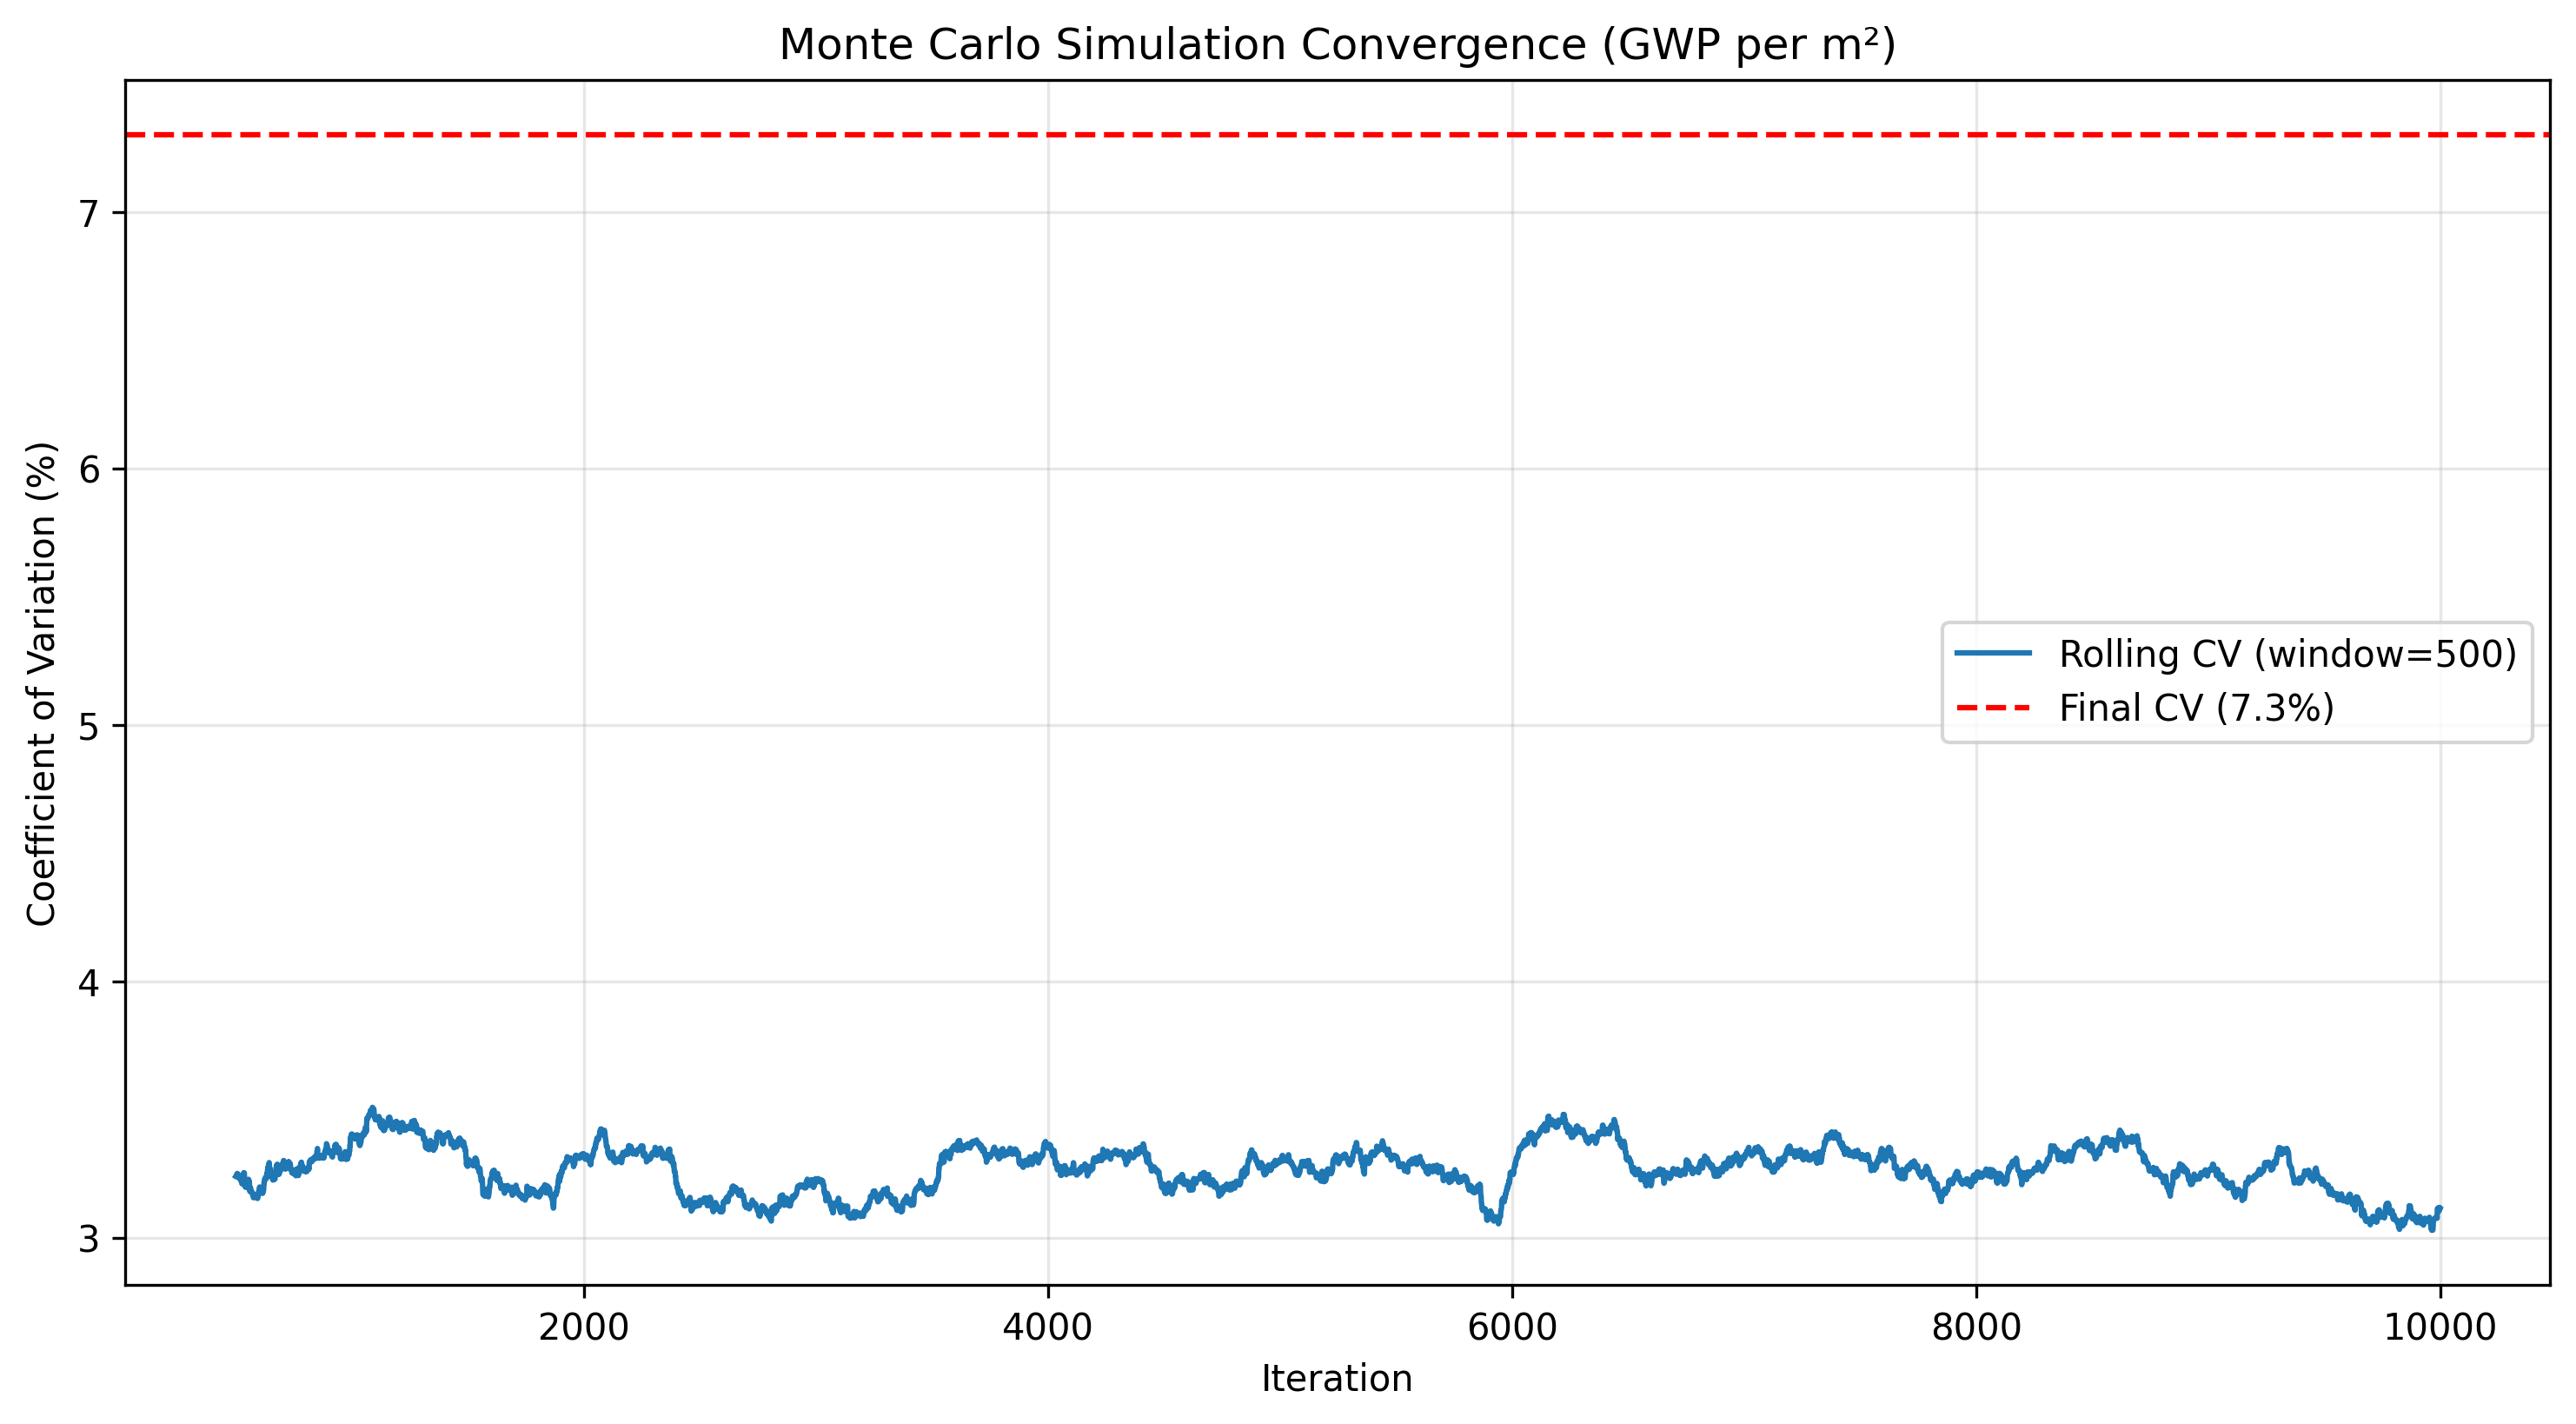

In [4]:
from IPython.display import Image
import os

# Ensure the output directory exists
OUTPUT_DIR = "mc_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Display the convergence plot
convergence_plot_path = os.path.join(OUTPUT_DIR, "mc_convergence.png")
if os.path.exists(convergence_plot_path):
    display(Image(filename=convergence_plot_path))
else:
    print(f"Convergence plot not found at {convergence_plot_path}")

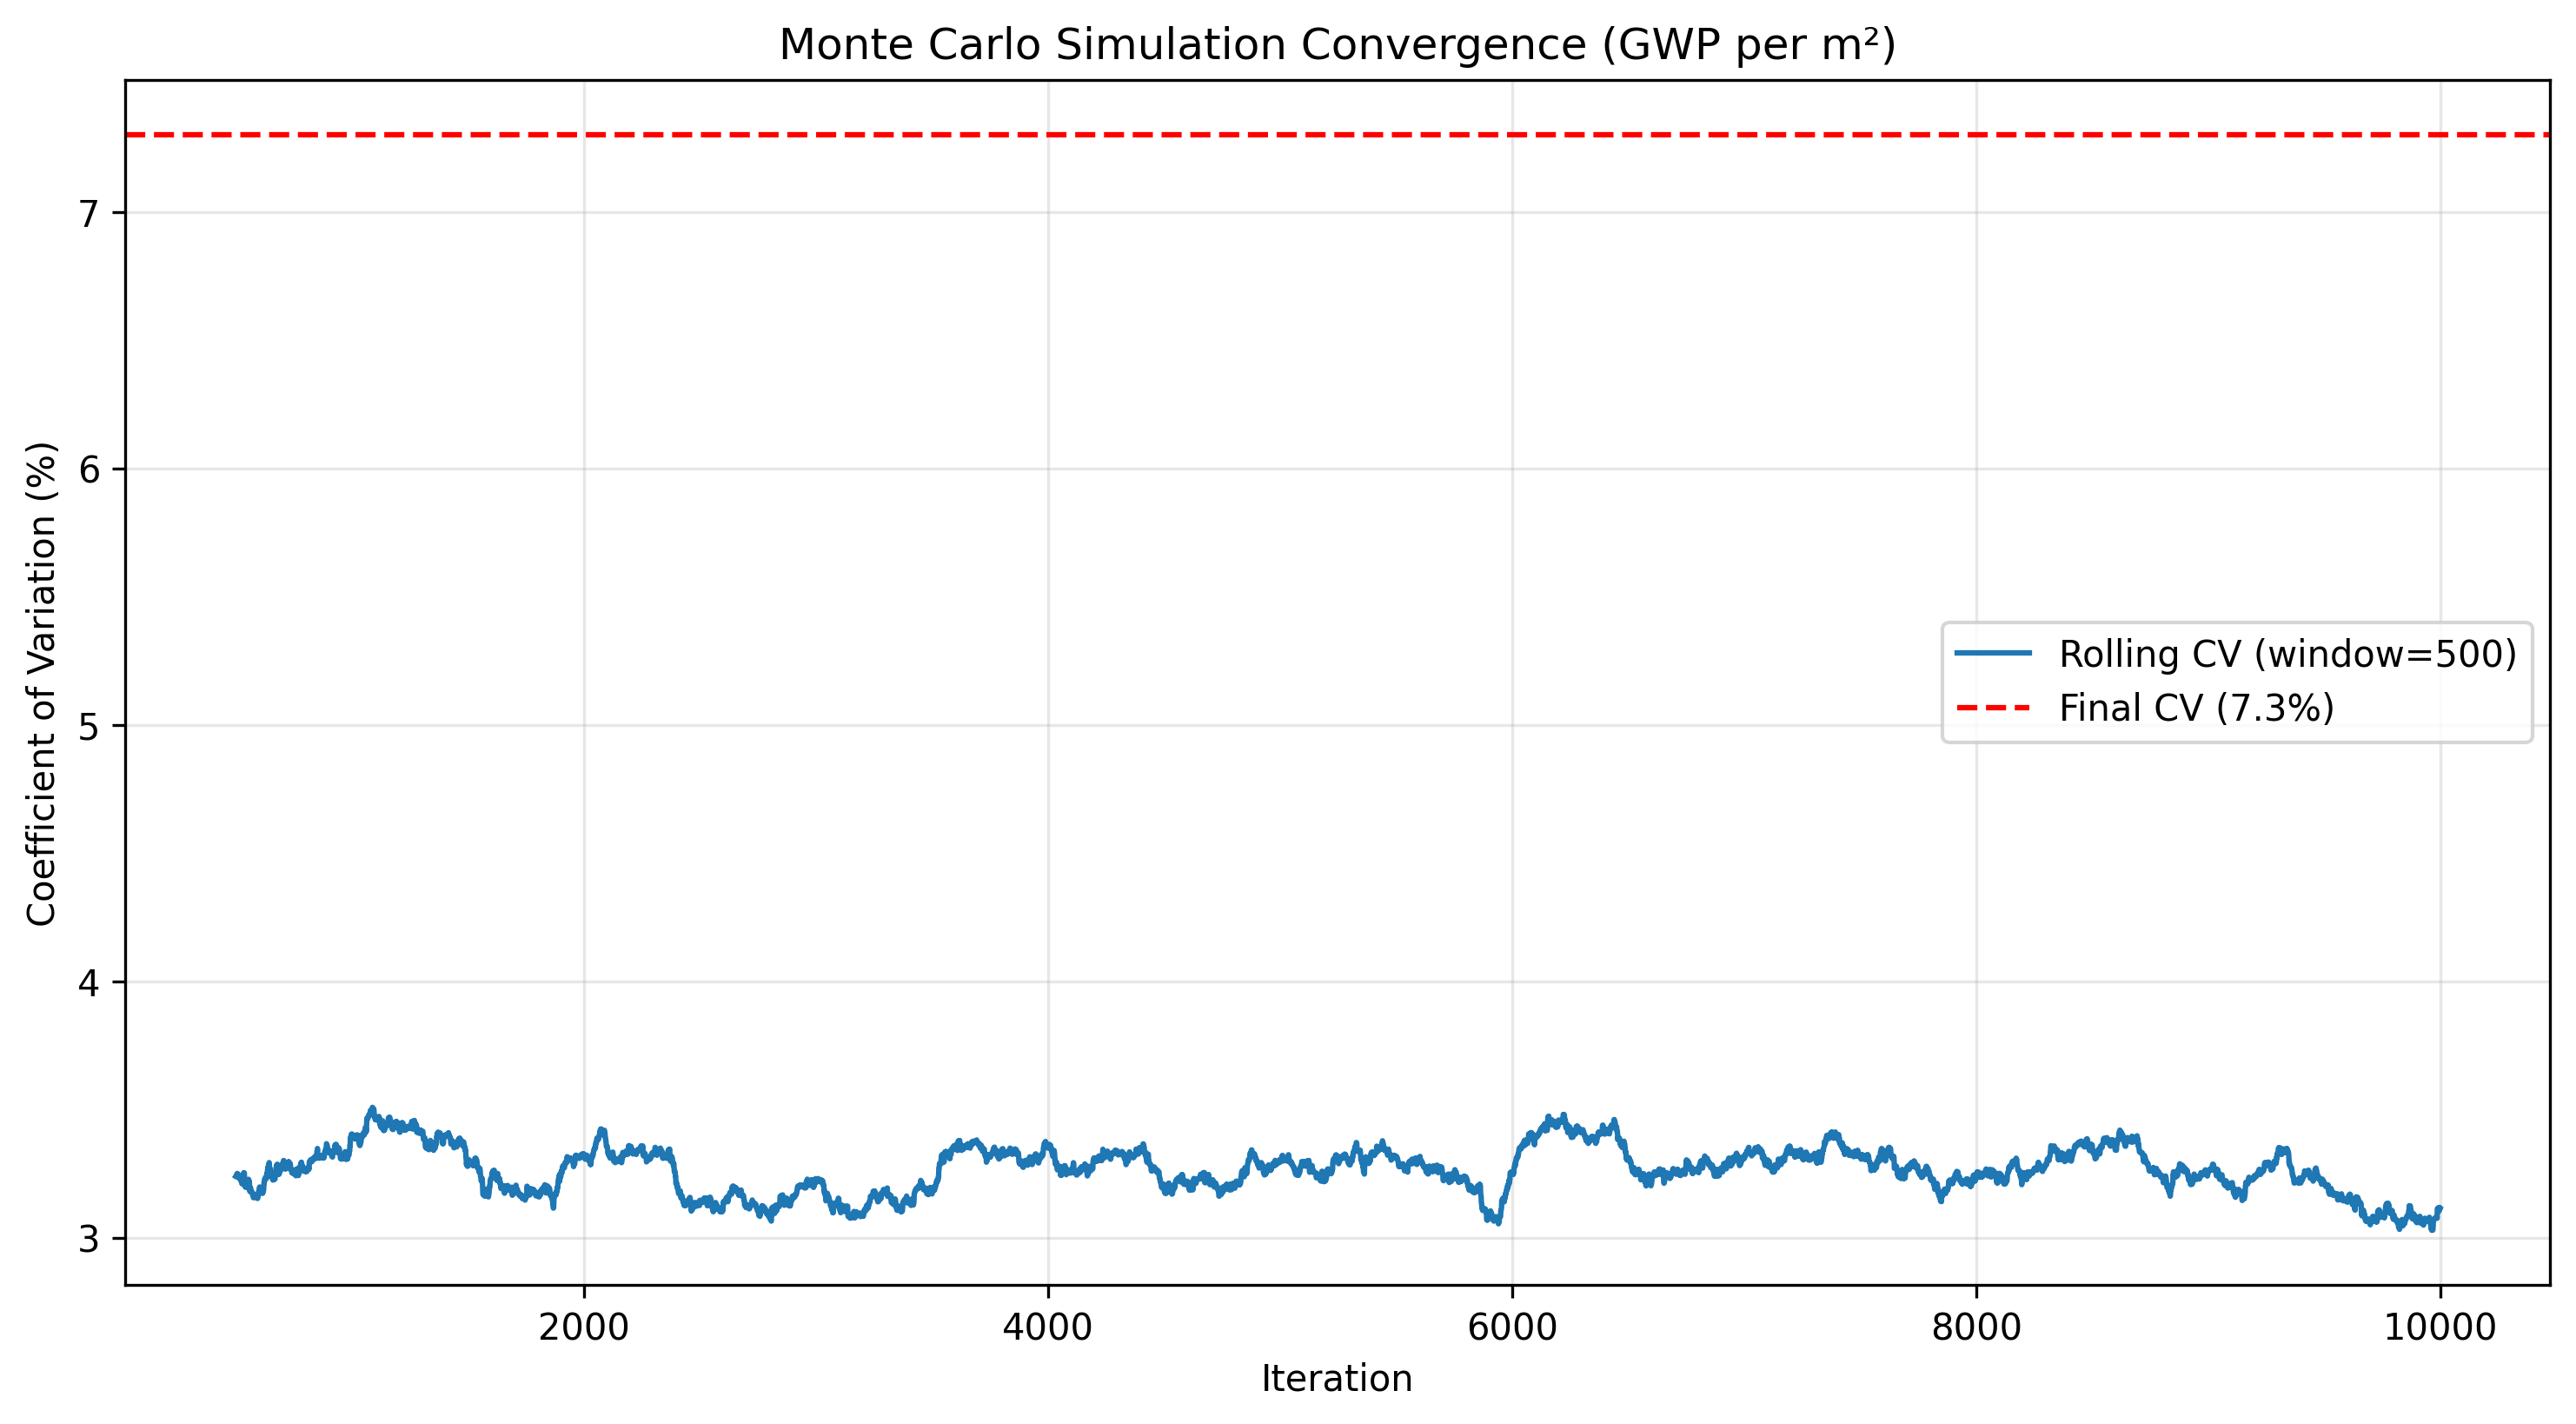

In [5]:
from IPython.display import Image
import os

# Ensure the output directory exists
OUTPUT_DIR = "mc_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Display the convergence plot
convergence_plot_path = os.path.join(OUTPUT_DIR, "mc_convergence.png")
if os.path.exists(convergence_plot_path):
    display(Image(filename=convergence_plot_path))
else:
    print(f"Convergence plot not found at {convergence_plot_path}")